## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [123]:
#Standard Processing libraries
import json 
import numpy as np
import pandas as pd
from tqdm import tqdm


#plotting Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from pprint import pprint


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV


#nltk libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import itertools 

from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
83.4MB [00:00, 116MB/s] 


In [3]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Clean up column names
  

df.rename(columns=lambda x: x.replace('_source.', ''), inplace=True)
df.rename(columns=lambda x: x.strip('_'), inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
##Create a Copy for Exploratory Data Analysis

df_eda = df.copy(deep=True)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [9]:
#Assign nan in place of blanks in the complaints column
 
df_eda['complaint_what_happened'] = np.where(df_eda['complaint_what_happened'] =='', np.nan, df_eda['complaint_what_happened'])
df_eda['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [16]:
cleaned_rows = df_eda['complaint_what_happened'].isna().sum()
ratio = round((cleaned_rows/len(df_eda))*100,2)
print(cleaned_rows)
print ("The Cleaned has {} rows from the original {} rows, which is only {}% of the dataset".format(cleaned_rows, len(df_eda), ratio))

57241
The Cleaned has 57241 rows from the original 78313 rows, which is only 73.09% of the dataset


In [29]:
#Remove all rows where complaints column is nan
df_eda= df_eda[~df_eda.complaint_what_happened.isna()]
df_eda = df_eda.astype({"complaint_what_happened":str})
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

In [30]:
rows_post_cleaning =  df_eda['complaint_what_happened'].isna().sum()
print ("Post cleaning we are now left with {} records".format(rows_post_cleaning))

Post cleaning we are now left with 0 records


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [31]:
#Lets first find patterns which we need to remove

brackets = df_eda.complaint_what_happened.filter(regex='\[\s*\w*\s*\]')
print("No of complaints with brackets = {}".format(len(brackets)))
print(brackets.to_string(index=False))


No of complaints with brackets = 0
Series([], )


In [18]:
numbers = df_eda.complaint_what_happened.filter(regex='\S*\d\S*')
print("No of complaints with numbers = {}".format(len(numbers)))
pd.set_option('display.max_colwidth', None)
print(numbers[:10])

No of complaints with numbers = 78313
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           NaN
1    Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Tha

In [34]:
import regex as re
import string
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text:str):
   text = text.lower()
   text = text.strip()
   text = re.sub("\[\s*\w*\s*\]", "", text)
   dictionary = "abc".maketrans('', '', string.punctuation)
   text = text.translate(dictionary)
   text = re.sub("\S*\d\S*", "", text)

   return text

df_eda.complaint_what_happened = pd.DataFrame(df_eda.complaint_what_happened.apply(lambda x: clean_text(x)))   

In [35]:
pd.set_option('display.max_colwidth', None)
df_eda.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to proc

### We will compare few lemmatizers and figure out which out to use using heuristics

In [36]:
#Write your function to Lemmatize the texts

# Convert the stop words to set to increase lookup effeciency
stops = set(stopwords.words('english'))


wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(document):
    'changes document by removing stopwords and generates Lemma'

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words and lemmatize
    words = [wordnet_lemmatizer.lemmatize(word) for word in words if word not in stops and word.isalpha()]

    # join words to make sentence
    document = " ".join(words)
    
    return document

df_eda['complaints_wordnet_lemma'] =  df_eda.complaint_what_happened.apply(lambda x: lemmatizer(x))   

In [37]:
#Write your function to Lemmatize the texts
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f5a57ea9e10>)]

In [38]:
## Using nlp pipes with chunking for faster execution 
def lemmatize_pipe(doc):
    lemma_list = [tok.lemma_.lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stops] 
    return lemma_list

def spacy_lemmatizer(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=40, disable=["tok2vec", "tagger", "parser", "ner"]):
       preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe



df_eda['complaints_spacy_lemma'] =  spacy_lemmatizer(df_eda.complaint_what_happened)



In [39]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df_eda[['complaint_what_happened', 'complaints_wordnet_lemma', 'complaints_spacy_lemma']].copy()

In [40]:
df_clean.head()


,complaint_what_happened,complaints_wordnet_lemma,complaints_spacy_lemma
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,"[good, morning, name, xxxx, xxxx, appreciate, can, help, put, stop, chase, bank, cardmember, service, write, chase, ask, debt, verification, send, statement, acceptable, ask, bank, validate, debt, instead, receive, mail, every, month, attempt, collect, debt, right, know, information, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thank, advance, help]"
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,"[upgrade, xxxx, xxxx, card, tell, agent, upgrade, anniversary, date, would, change, turn, agent, give, wrong, information, order, upgrade, account, xxxx, change, anniversary, date, xxxxxxxx, xxxxxxxx, without, consent, xxxx, record, agent, mislead]"
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant,"[chase, card, report, however, fraudulent, application, submit, identity, without, consent, fraudulently, obtain, service, extend, credit, without, verify, identity, applicant]"
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not c

In [94]:
df_eda.complaint_what_happened

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [43]:
#Write your function to extract the POS tags 

## Using nlp pipes with chunking for faster execution 
def filter_pipe(doc):
    pos_list=[]
    for tok in doc:
       if tok.is_alpha and tok.text.lower() not in stops:
         pos_list.append(tok.pos_.lower())
    return pos_list

def spacy_pos(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=1, disable=["tok2vec", "lemmatizer", "parser", "ner"]):
       preproc_pipe.append(filter_pipe(doc))
    return preproc_pipe



df_clean['complaints_pos_tags'] =  spacy_pos(df_eda.complaint_what_happened)

In [105]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaints_wordnet_lemma,complaints_spacy_lemma,complaints_pos_tags
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,"[good, morning, name, xxxx, xxxx, appreciate, can, help, put, stop, chase, bank, cardmember, service, write, chase, ask, debt, verification, send, statement, acceptable, ask, bank, validate, debt, instead, receive, mail, every, month, attempt, collect, debt, right, know, information, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thank, advance, help]","[adj, noun, noun, propn, propn, verb, verb, verb, verb, noun, verb, noun, noun, noun, verb, verb, verb, noun, noun, verb, noun, adj, verb, noun, verb, noun, adv, verb, noun, det, noun, verb, verb, noun, noun, verb, noun, noun, noun, noun, propn, propn, propn, propn, noun, noun, noun]"
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,"[upgrade, xxxx, xxxx, card, tell, agent, upgrade, anniversary, date, would, change, turn, agent, give, wrong, information, order, upgrade, account, xxxx, change, anniversary, date, xxxxxxxx, xxxxxxxx, without, consent, xxxx, record, agent, mislead]","[verb, propn, propn, noun, verb, noun, verb, noun, noun, verb, verb, verb, noun, verb, adj, noun, noun, verb, noun, propn, verb, noun, noun, propn, propn, adp, noun, noun, noun, noun, verb]"
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant,"[chase, card, report, however, fraudulent, application, submit, identity, without, consent, fraudulently, obtain, service, extend, credit, without, verify, identity, applicant]","[propn, noun, verb, adv, adj, noun, verb, noun, adp, noun, adv, verb, noun, verb, noun, adp, verb, noun, noun]"
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told 

In [106]:
df_clean.to_csv("df_clean.csv")

In [108]:
from google.colab import drive
drive.mount('/content/drive')

!!cp df_clean.csv /content/drive/MyDrive

#to Copy back 
#!cp  /content/drive/MyDrive/df_clean.csv .

Mounted at /content/drive


[]

In [ ]:
#Load from checkpointed df_clean

#df_clean = pd.read_csv('df_clean.csv')

In [113]:
#pd.set_option('display.max_colwidth', None)
df_clean.head()

,complaint_what_happened,complaints_wordnet_lemma,complaints_spacy_lemma,complaints_pos_tags
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,"[good, morning, name, xxxx, xxxx, appreciate, can, help, put, stop, chase, bank, cardmember, service, write, chase, ask, debt, verification, send, statement, acceptable, ask, bank, validate, debt, instead, receive, mail, every, month, attempt, collect, debt, right, know, information, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thank, advance, help]","[adj, noun, noun, propn, propn, verb, verb, verb, verb, noun, verb, noun, noun, noun, verb, verb, verb, noun, noun, verb, noun, adj, verb, noun, verb, noun, adv, verb, noun, det, noun, verb, verb, noun, noun, verb, noun, noun, noun, noun, propn, propn, propn, propn, noun, noun, noun]"
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,"[upgrade, xxxx, xxxx, card, tell, agent, upgrade, anniversary, date, would, change, turn, agent, give, wrong, information, order, upgrade, account, xxxx, change, anniversary, date, xxxxxxxx, xxxxxxxx, without, consent, xxxx, record, agent, mislead]","[verb, propn, propn, noun, verb, noun, verb, noun, noun, verb, verb, verb, noun, verb, adj, noun, noun, verb, noun, propn, verb, noun, noun, propn, propn, adp, noun, noun, noun, noun, verb]"
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant,"[chase, card, report, however, fraudulent, application, submit, identity, without, consent, fraudulently, obtain, service, extend, credit, without, verify, identity, applicant]","[propn, noun, verb, adv, adj, noun, verb, noun, adp, noun, adv, verb, noun, verb, noun, adp, verb, noun, noun]"
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told 

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



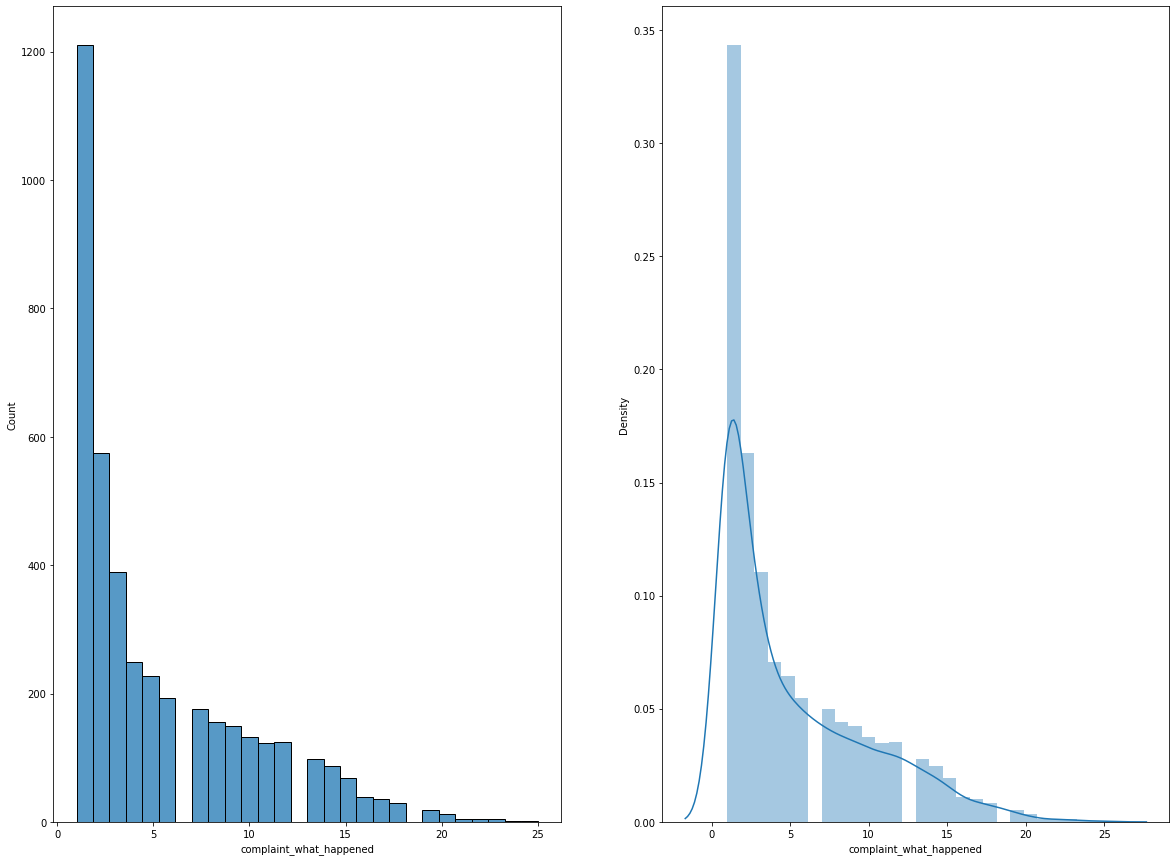

In [134]:
# Write your code here to visualise the data according to the 'Complaint' character length

def count_words(sent : string):
  print(len(sent.split()))


df_clean['complaint_length'] = df_clean['complaint_what_happened'].apply(lambda x: len(x))

plt.figure(figsize=(20, 15))
fig = plt.subplot(1,2,1)

distrib = df_clean.groupby(by='complaint_length')['complaint_what_happened'].count()
sns.histplot(distrib)

fig = plt.subplot(1,2,2)
sns.distplot(distrib)

In [ ]:

distrib = df_clean.groupby(by='complaint_length')['complaint_what_happened'].count()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [161]:
df_clean.complaints_wordnet_lemma= df_clean.complaints_wordnet_lemma.astype('string')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   complaint_what_happened   21072 non-null  object 
 1   complaints_wordnet_lemma  21072 non-null  string 
 2   complaints_spacy_lemma    21072 non-null  object 
 3   complaints_pos_tags       21072 non-null  object 
 4   complaint_length          21072 non-null  int64  
 5   Complaint_clean           0 non-null      float64
 6   complaint_clean           0 non-null      float64
dtypes: float64(2), int64(1), object(3), string(1)
memory usage: 1.9+ MB


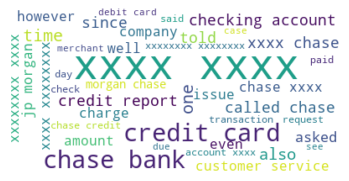

In [174]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stops,max_words=40, max_font_size=50, background_color='white').generate(' '.join(df_clean.complaint_what_happened))

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [48]:
#Removing -PRON- from the text corpus
#This is no longer required for the latest version of Spacy, but we will execute the same, in case some have creeped in.
df_clean.complaints_spacy_lemma = df_clean.complaints_spacy_lemma.apply(lambda x: ' '.join(x))
df_clean['complaint_clean'] = df_clean.complaints_spacy_lemma.str.replace('-PRON-', '')

In [49]:
#All -PRON- texts has been removed
df_clean.head()

,complaint_what_happened,complaints_wordnet_lemma,complaints_spacy_lemma,complaints_pos_tags,complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,good morning name xxxx xxxx appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,"[adj, noun, noun, propn, propn, verb, verb, verb, verb, noun, verb, noun, noun, noun, verb, verb, verb, noun, noun, verb, noun, adj, verb, noun, verb, noun, adv, verb, noun, det, noun, verb, verb, noun, noun, verb, noun, noun, noun, noun, propn, propn, propn, propn, noun, noun, noun]",good morning name xxxx xxxx appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead,"[verb, propn, propn, noun, verb, noun, verb, noun, noun, verb, verb, verb, noun, verb, adj, noun, noun, verb, noun, propn, verb, noun, noun, propn, propn, adp, noun, noun, noun, noun, verb]",upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,"[propn, noun, verb, adv, adj, noun, verb, noun, adp, noun, adv, verb, noun, verb, noun, adp, verb, noun, noun]",chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within les

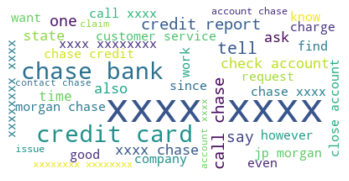

In [50]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))
wordcloud = WordCloud(stopwords=stoplist,max_words=40, max_font_size=50, background_color='white').generate(' '.join(df_clean.complaint_clean))

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [46]:
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


--1 [[ 1  1  1 ... 33  1  3]]
good
9865


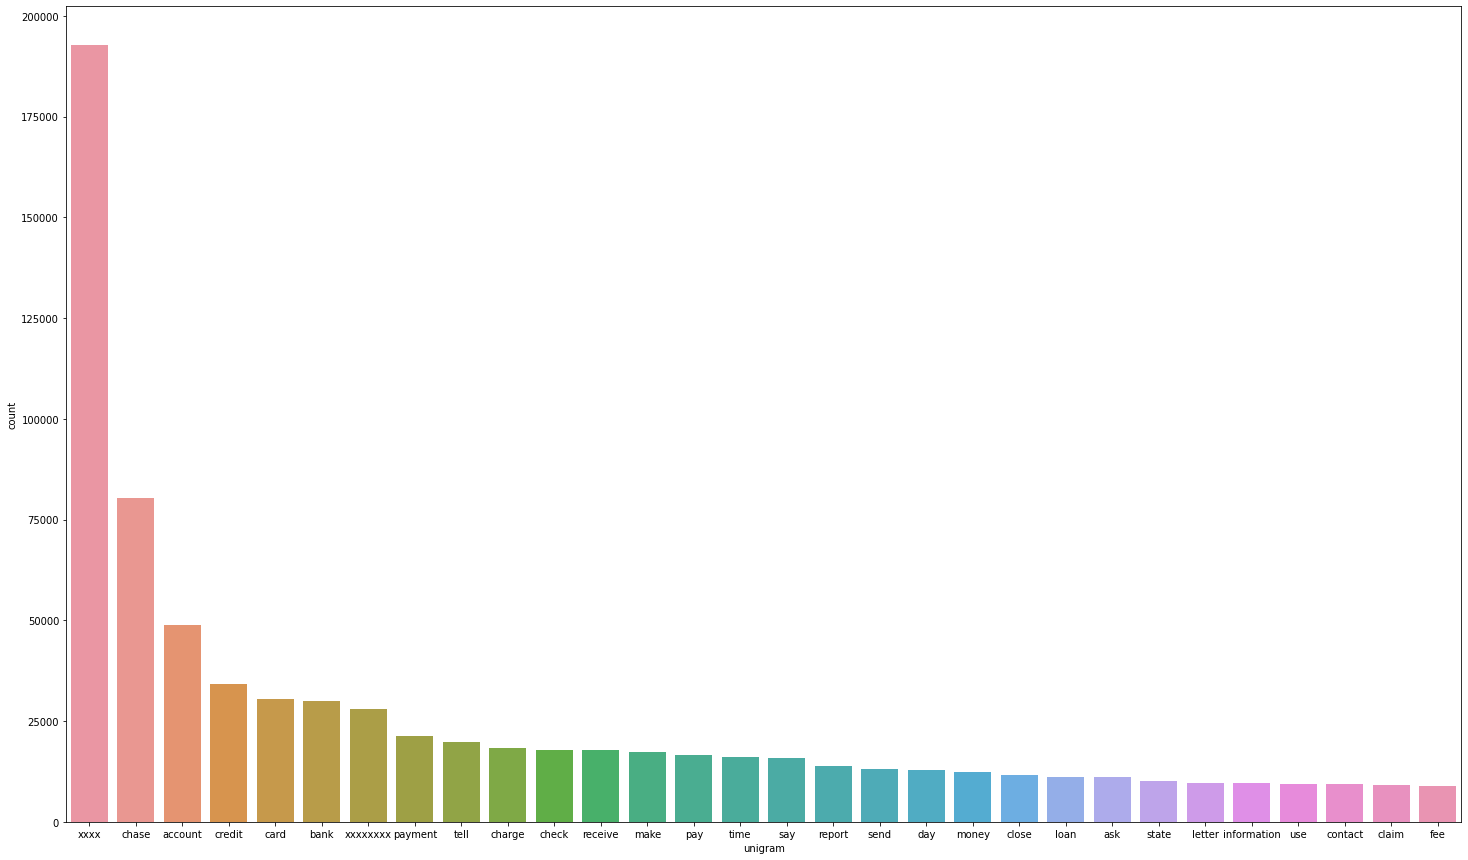

In [189]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.complaint_clean, 1, 30)
df3 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
plt.figure(figsize=[25,15])
fig = sns.barplot(x=df3['unigram'], y=df3['count'])


In [51]:
#Print the top 10 words in the unigram frequency
common_words = get_top_n_ngram(df_clean.complaint_clean, 1, 10)
pd.DataFrame(common_words)

--1 [[ 1  1  1 ... 33  1  3]]


,0,1
0,xxxx,192692
1,chase,80402
2,account,48895
3,credit,34174
4,card,30528
5,bank,30056
6,xxxxxxxx,27926
7,payment,21172
8,tell,19680
9,charge,18246


--1 [[1 1 1 ... 1 1 1]]


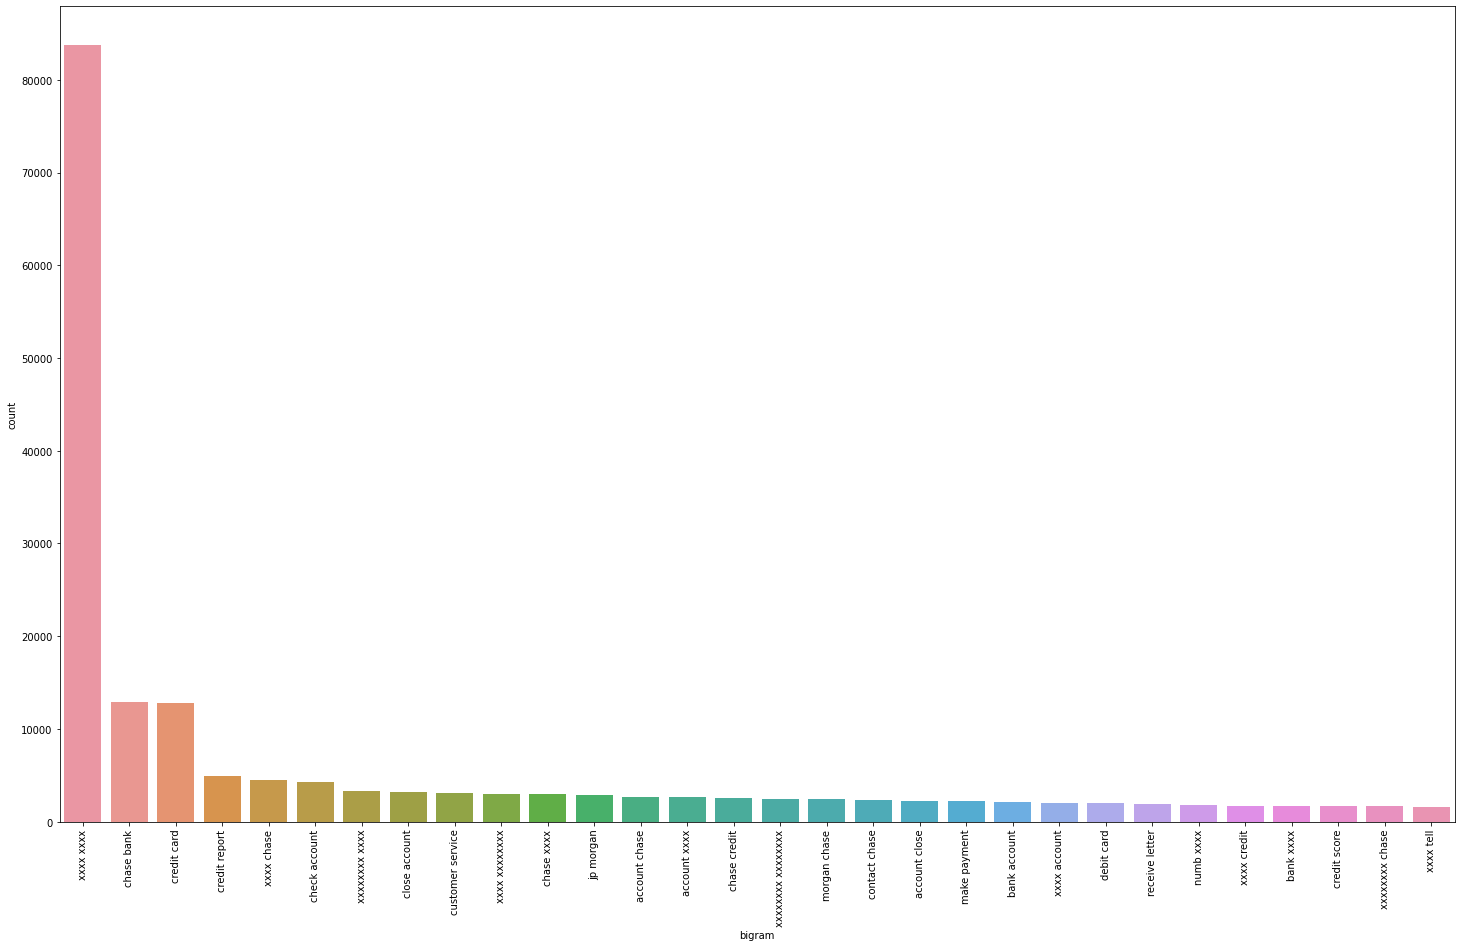

In [55]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.complaint_clean, 2, 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=90)
fig = sns.barplot(x=df3['bigram'], y=df3['count'])


In [211]:
#Print the top 10 words in the bigram frequency
pd.DataFrame(common_words).sort_values(by=1,ascending=False )[:10]

,0,1
0,xxxx xxxx,83745
1,chase bank,12911
2,credit card,12812
3,credit report,4945
4,xxxx chase,4450
5,check account,4296
6,xxxxxxxx xxxx,3334
7,close account,3218
8,customer service,3066
9,xxxx xxxxxxxx,2990


--1 [[1 1 1 ... 1 1 1]]


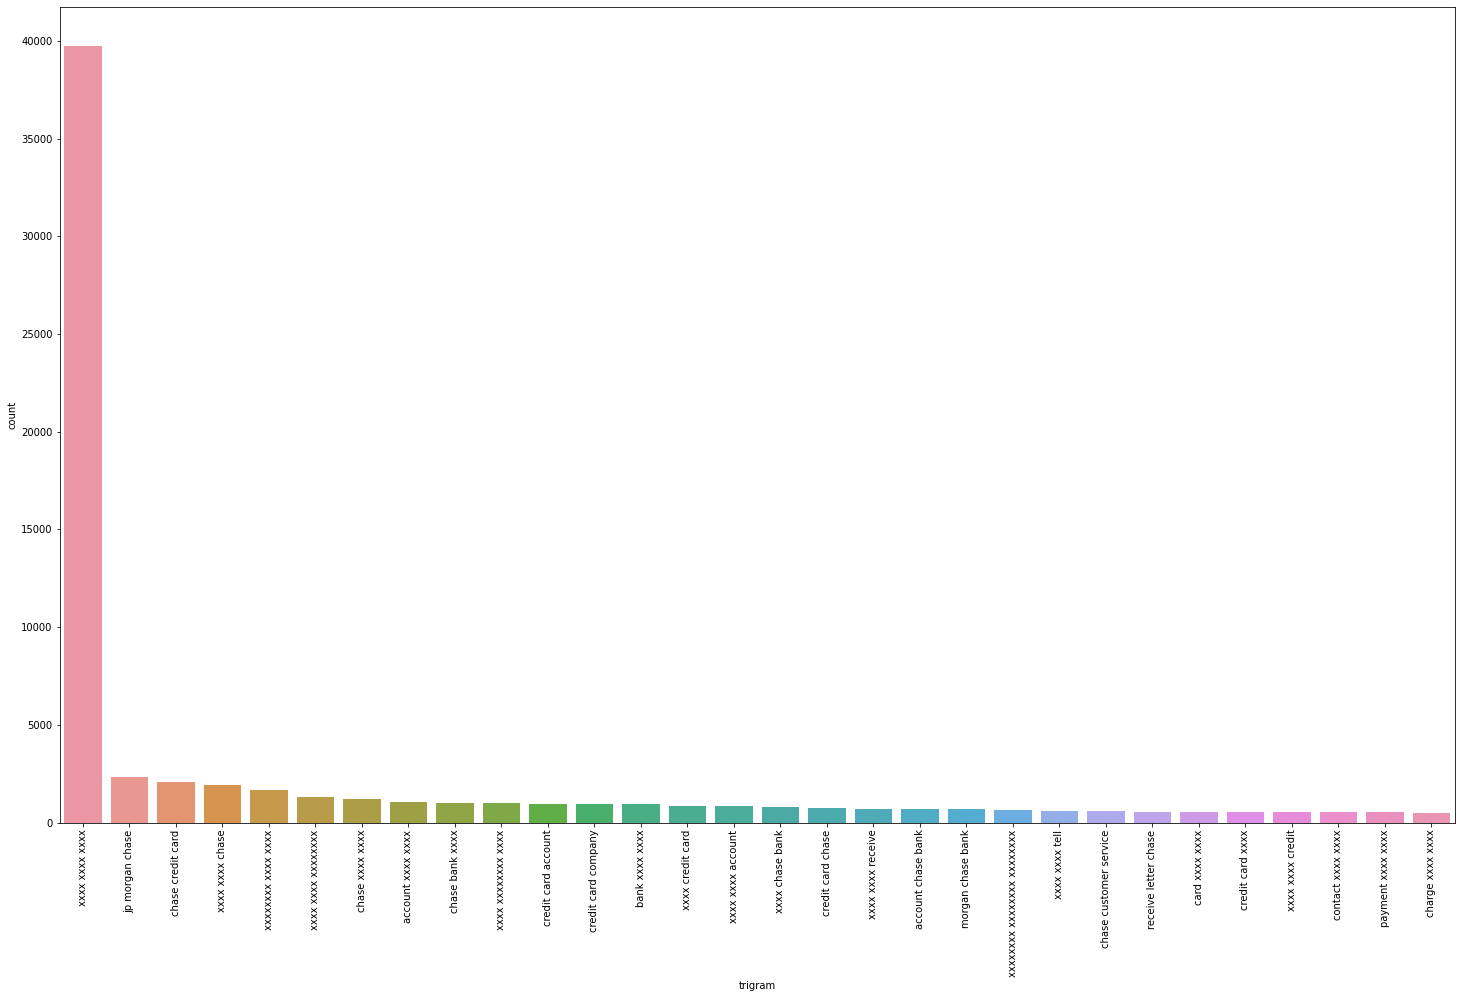

In [52]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_clean.complaint_clean, 3, 30)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=90)
fig = sns.barplot(x=df3['trigram'], y=df3['count'])

In [214]:
#Print the top 10 words in the trigram frequency
pd.DataFrame(common_words).sort_values(by=1,ascending=False )[:10]

,0,1
0,xxxx xxxx xxxx,39736
1,jp morgan chase,2350
2,chase credit card,2099
3,xxxx xxxx chase,1907
4,xxxxxxxx xxxx xxxx,1654
5,xxxx xxxx xxxxxxxx,1319
6,chase xxxx xxxx,1191
7,account xxxx xxxx,1052
8,chase bank xxxx,1014
9,xxxx xxxxxxxx xxxx,989


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [215]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [216]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaints_wordnet_lemma,complaints_spacy_lemma,complaints_pos_tags,complaint_length,Complaint_clean,complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,good morning name xxxx xxxx appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,"[adj, noun, noun, propn, propn, verb, verb, verb, verb, noun, verb, noun, noun, noun, verb, verb, verb, noun, noun, verb, noun, adj, verb, noun, verb, noun, adv, verb, noun, det, noun, verb, verb, noun, noun, verb, noun, noun, noun, noun, propn, propn, propn, propn, noun, noun, noun]",475,NaN,good morning name appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead,"[verb, propn, propn, noun, verb, noun, verb, noun, noun, verb, verb, verb, noun, verb, adj, noun, noun, verb, noun, propn, verb, noun, noun, propn, propn, adp, noun, noun, noun, noun, verb]",337,NaN,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent record agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,"[propn, noun, verb, adv, adj, noun, verb, noun, adp, noun, adv, verb, noun, verb, noun, adp, verb, noun, noun]",210,NaN,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a mi

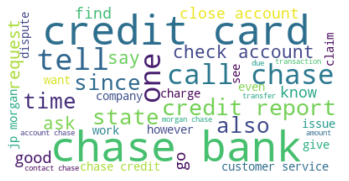

In [219]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))


wordcloud = WordCloud(stopwords=stoplist,max_words=40,max_font_size=50, background_color='white').generate(' '.join(df_clean.complaint_clean))

#print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [54]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [56]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.complaint_clean.astype('U').values)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [57]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [58]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [59]:
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_
len(tfidf.get_feature_names())

11271

In [60]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i+1}' for i in range(num_topics)],
                columns=[f'Word {i + 1}' for i in range(15)]).astype('str')

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]
topic_words                

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,xxxx,chase,xxxxxxxx,bank,numb,send,contact,email,file,money,complaint,state,say,xxxxxxxxxxxx,receive
Topic 2,account,check,bank,chase,close,deposit,money,fund,tell,open,branch,day,say,transfer,business
Topic 3,credit,report,card,inquiry,account,chase,remove,hard,apply,score,bureau,company,open,close,information
Topic 4,payment,loan,mortgage,pay,chase,xxxxxxxx,late,make,month,modification,home,time,year,rate,balance
Topic 5,charge,card,chase,dispute,xxxxxxxx,fee,transaction,purchase,merchant,refund,receive,claim,fraud,tell,service



#### Topic 1 looks to be "Bank account services"
#### Topic 2 looks to be "Credit card / Prepaid card"
#### Topic 3 looks to be "Mortgages/loans"
#### Topic 4 looks to be "Theft/Dispute reporting"
#### Topic 5 looks to be "Others"

In [63]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic {}".format(i) for i in range(nmf_model.n_components)]
complaintnames = ["Complaint {}".format(i) for i in range(len(df_clean.index))]
df_doc_topic = pd.DataFrame(np.round(W, 2), columns=colnames, index=complaintnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_clean['topic_tar'] = significant_topic

In [64]:
df_doc_topic

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,dominant_topic
Complaint 0,0.05,0.03,0.01,0.02,0.01,0
Complaint 1,0.02,0.00,0.00,0.01,0.01,0
Complaint 2,0.00,0.00,0.05,0.00,0.01,2
Complaint 3,0.02,0.02,0.05,0.01,0.02,2
Complaint 4,0.01,0.08,0.00,0.00,0.00,1
...,...,...,...,...,...,...
Complaint 21067,0.00,0.00,0.05,0.00,0.06,4
Complaint 21068,0.01,0.01,0.00,0.01,0.04,4
Complaint 21069,0.02,0.03,0.01,0.01,0.02,1
Complaint 21070,0.00,0.00,0.02,0.06,0.04,3


In [65]:
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)], index=[f'Complaint {i+1}' for i in range(W.shape[0])])
#W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W[pd.notnull(W['max_topic'])].head(10)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
Complaint 1,0.048846,0.025539,0.009987,0.017117,0.008017,Topic 1
Complaint 2,0.024821,0.004098,0.003671,0.006019,0.014612,Topic 1
Complaint 3,0.000097,0.000000,0.051784,0.000000,0.008168,Topic 3
Complaint 4,0.016251,0.023770,0.052485,0.013042,0.016793,Topic 3
Complaint 5,0.011685,0.076639,0.000000,0.003802,0.000000,Topic 2
Complaint 6,0.000000,0.000000,0.060612,0.000000,0.000000,Topic 3
Complaint 7,0.000344,0.069244,0.001761,0.016330,0.008431,Topic 2
Complaint 8,0.023062,0.004567,0.002121,0.055522,0.005899,Topic 4
Complaint 9,0.024397,0.033743,0.000000,0.009131,0.051522,Topic 5
Complaint 10,0.000048,0.000000,0.104199,0.000000,0.002652,Topic 3


In [66]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.max_topic.values

In [253]:
df_clean.head()

,complaint_what_happened,complaints_wordnet_lemma,complaints_spacy_lemma,complaints_pos_tags,complaint_length,Complaint_clean,complaint_clean,topic_tar,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,good morning name xxxx xxxx appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,"[adj, noun, noun, propn, propn, verb, verb, verb, verb, noun, verb, noun, noun, noun, verb, verb, verb, noun, noun, verb, noun, adj, verb, noun, verb, noun, adv, verb, noun, det, noun, verb, verb, noun, noun, verb, noun, noun, noun, noun, propn, propn, propn, propn, noun, noun, noun]",475,NaN,good morning name appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help,2,Topic 3
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead,"[verb, propn, propn, noun, verb, noun, verb, noun, noun, verb, verb, verb, noun, verb, adj, noun, noun, verb, noun, propn, verb, noun, noun, propn, propn, adp, noun, noun, noun, noun, verb]",337,NaN,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent record agent mislead,2,Topic 4
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,"[propn, noun, verb, adv, adj, noun, verb, noun, adp, noun, adv, verb, noun, verb, noun, adp, verb, noun, noun]",210,NaN,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,1,Topic 2
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my infor

In [254]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,complaints_wordnet_lemma,complaints_spacy_lemma,complaints_pos_tags,complaint_length,Complaint_clean,complaint_clean,topic_tar,Topic
27,i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the terms and was told everything was on the account and once i made xxxx direct deposit the bonus would be paid out in days as of xxxx i had made the required deposits and was told my account never had the coupon code applied and it was past the days to do so so no bonus would be paid,opened account chase bank xxxx used code xxxx bonus called follow xxxxxxxx term told everything account made xxxx direct deposit bonus would paid day xxxx made required deposit told account never coupon code applied past day bonus would paid,open account chase bank xxxx use code xxxx bonus call follow xxxxxxxx term tell everything account make xxxx direct deposit bonus would pay day xxxx make require deposit tell account never coupon code apply past day bonus would pay,"[verb, noun, propn, propn, propn, verb, noun, propn, propn, verb, verb, noun, noun, verb, pron, noun, verb, propn, adj, noun, noun, verb, verb, noun, propn, verb, adj, noun, verb, noun, adv, noun, noun, verb, adp, noun, noun, verb, verb]",403,NaN,open account chase bank use code bonus call follow term tell everything account make direct deposit bonus would pay day make require deposit tell account never coupon code apply past day bonus would pay,0,Topic 1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,grand son give check deposit chase account fund clear chase bank closed account never paid money said need speek grand son check clear money taking chase bank refuse pay money grand son called chase time told call verify check owner country time date happen check number xxxx claim number xxxx chase,grand son give check deposit chase account fund clear chase bank close account never pay money say need speek grand son check clear money take chase bank refuse pay money grand son call chase time tell call verify check owner country time date happen check numb xxxx claim numb xxxx chase,"[adj, noun, verb, verb, verb, noun, noun, noun, adj, propn, noun, verb, noun, adv, verb, noun, verb, verb, verb, adj, noun, noun, adj, noun, verb, propn, noun, verb, verb, noun, adj, noun, verb, propn, noun, verb, verb, verb, noun, noun, noun, noun, noun, verb, noun, noun, noun, noun, noun, verb, propn]",456,NaN,grand son give check deposit chase account fund clear chase bank close account never pay money say need speek grand son check clear money take chase bank refuse pay money grand son call chase time tell call verify check owner country time date happen check numb claim numb chase,0,Topic 1
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [67]:
#Create the dictionary of Topic names and Topics


Topic_names = {
    'Topic 1': 'Bank account services',
    'Topic 2': 'Credit card / Prepaid card',
    'Topic 3': 'Mortgages/loans',
    'Topic 4': 'Theft/Dispute reporting',
    'Topic 5': 'Others'   
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [68]:
df_clean.head()

,complaint_what_happened,complaints_wordnet_lemma,complaints_spacy_lemma,complaints_pos_tags,complaint_clean,topic_tar,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,good morning name xxxx xxxx appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,"[adj, noun, noun, propn, propn, verb, verb, verb, verb, noun, verb, noun, noun, noun, verb, verb, verb, noun, noun, verb, noun, adj, verb, noun, verb, noun, adv, verb, noun, det, noun, verb, verb, noun, noun, verb, noun, noun, noun, noun, propn, propn, propn, propn, noun, noun, noun]",good morning name xxxx xxxx appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,0,Bank account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead,"[verb, propn, propn, noun, verb, noun, verb, noun, noun, verb, verb, verb, noun, verb, adj, noun, noun, verb, noun, propn, verb, noun, noun, propn, propn, adp, noun, noun, noun, noun, verb]",upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead,0,Bank account services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,"[propn, noun, verb, adv, adj, noun, verb, noun, adp, noun, adv, verb, noun, verb, noun, adp, verb, noun, noun]",chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,2,Mortgages/loans
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [69]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank account services' : 1,
    'Credit card / Prepaid card': 2,
    'Mortgages/loans' : 3,
    'Theft/Dispute reporting': 4,
    'Others': 5   
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [70]:
df_clean

,complaint_what_happened,complaints_wordnet_lemma,complaints_spacy_lemma,complaints_pos_tags,complaint_clean,topic_tar,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help,good morning name xxxx xxxx appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,"[adj, noun, noun, propn, propn, verb, verb, verb, verb, noun, verb, noun, noun, noun, verb, verb, verb, noun, noun, verb, noun, adj, verb, noun, verb, noun, adv, verb, noun, det, noun, verb, verb, noun, noun, verb, noun, noun, noun, noun, propn, propn, propn, propn, noun, noun, noun]",good morning name xxxx xxxx appreciate can help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thank advance help,0,1
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgraded xxxx xxxx card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account xxxx changed anniversary date xxxxxxxx xxxxxxxx without consent xxxx recording agent misled,upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead,"[verb, propn, propn, noun, verb, noun, verb, noun, noun, verb, verb, verb, noun, verb, adj, noun, noun, verb, noun, propn, verb, noun, noun, propn, propn, adp, noun, noun, noun, noun, verb]",upgrade xxxx xxxx card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx without consent xxxx record agent mislead,0,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card reported however fraudulent application submitted identity without consent fraudulently obtain service extend credit without verifying identity applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,"[propn, noun, verb, adv, adj, noun, verb, noun, adp, noun, adv, verb, noun, verb, noun, adp, verb, noun, noun]",chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,2,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information 

In [71]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [ ]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,3
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,4
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,2
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,2
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,1
15,can you please remove inquiry,2
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three busin

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [72]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X = count_vect.fit_transform(training_data.complaint_what_happened)


#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X)

y= training_data.Topic

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [73]:
# Write your code here to build any 3 models and evaluate them using the required metrics

y.head()

1     1
2     1
10    3
11    3
14    2
Name: Topic, dtype: int64

In [114]:
y = y.values.reshape(-1,1)

In [115]:
y.shape, X.shape

((21072, 1), (21072, 33621))

#### Lets create a baseline result using Decision Trees 
We can then use this to visualize the results and also improve on the same using other algorithms

In [108]:
##Function for training models and testing on a test set. if plot is True, plots the confusion matrix
def model_fit(alg, X_train_data, y_train_data, X_test_data, y_test_data, plot=True):
    
    #Fit the algorithm on the data
    alg.fit(X_train_data, y_train_data)
        
    #Predict training set:
    y_train_pred = alg.predict(X_train_data)
    y_test_pred = alg.predict(X_test_data)
      
    computeClassificationMetrics(y_test, y_test_pred, plot)

In [102]:
 #This function plots the confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [106]:
#Utility Libraries

## For y_true and y_pred display the Classification Metrics and plot Confusion Matrix
def computeClassificationMetrics(y_test,y_test_pred, plot=True):
        print('*'*20+"Classification Report"+'*'*20)
        print(classification_report(y_test,y_test_pred))
        
        if plot:
            # Compute confusion matrix
            cnf_matrix = confusion_matrix(y_test, y_test_pred)
            print('*'*20+'Confusion Matrix'+'*'*20)
            # Plot non-normalized confusion matrix
            class_names = [1,2,3,4,5]
            plt.figure(figsize=(7,5))
            plot_confusion_matrix(cnf_matrix
                      , classes=class_names)                      
            plt.show()

In [97]:
#Using Decision Trees

#Initialize Imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

#Initialize Graph Libraries

from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz



In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((14750, 33621), (6322, 33621))

In [96]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [94]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [95]:
print(accuracy_score(y_test, y_test_pred))
confusion_matrix(y_train, y_train_pred)

0.713856374565011


array([[2929,   64,   32,   46,   65],
       [  74, 3094,   73,   71,   55],
       [  39,   42, 2183,   50,  117],
       [  53,   55,   49, 2620,   50],
       [ 111,   93,   89,  100, 2596]])

********************Classification Report********************
              precision    recall  f1-score   support

           1       0.69      0.72      0.71      1337
           2       0.75      0.72      0.73      1496
           3       0.75      0.74      0.74      1040
           4       0.71      0.73      0.72      1173
           5       0.68      0.67      0.68      1276

    accuracy                           0.71      6322
   macro avg       0.71      0.71      0.71      6322
weighted avg       0.71      0.71      0.71      6322

********************Confusion Matrix********************


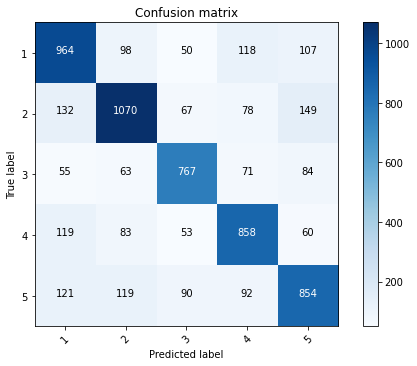

In [107]:
#Visualizing the graph

computeClassificationMetrics(y_test, y_test_pred, True)

#### Using Random Forests 
Lets see if we can improve on the 0.71 score using Random Forests and increase bias in the model
We will also tune the hyperparameters here to optimize the model for this data set. 

In [110]:
#### Base Random Forest Model :

# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



********************Classification Report********************
              precision    recall  f1-score   support

           1       0.74      0.44      0.55      1337
           2       0.74      0.90      0.81      1496
           3       0.80      0.81      0.80      1040
           4       0.77      0.83      0.80      1173
           5       0.73      0.81      0.77      1276

    accuracy                           0.76      6322
   macro avg       0.76      0.76      0.75      6322
weighted avg       0.76      0.76      0.74      6322

********************Confusion Matrix********************


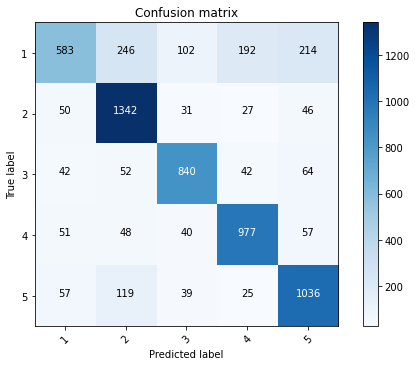

In [120]:
# Call model fit and evalute the validation set
model_fit(rfc,X_train, y_train, X_test, y_test ,True)

#### We will try to tune the Random Forest using heuristic values of Grid Search CV

In [138]:
def tune_hyperparameter(parameters,x_train,y_train,n_folds = 5,max_depth=0):
    
    if(max_depth==0):
        rf = RandomForestClassifier(random_state=0)
    else :
        rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
        
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True, verbose=3)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



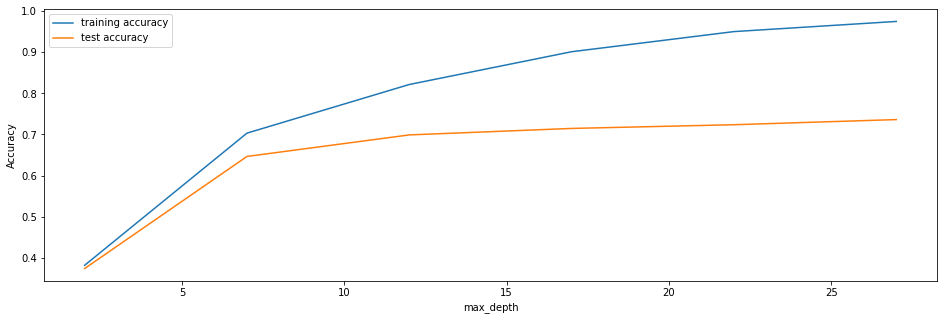

In [130]:
# parameters to build the model on
parameters = {'max_depth': range(2, 30, 5)}
tune_hyperparameter(parameters,X_train, y_train)

###### Max Depth of 5-9 can be good starting point for the training

In [140]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 1000, 200)}
tune_hyperparameter(parameters,X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



KeyboardInterrupt: ignored

#### - Results in too long iterations. We will go with the defaults

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.0min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



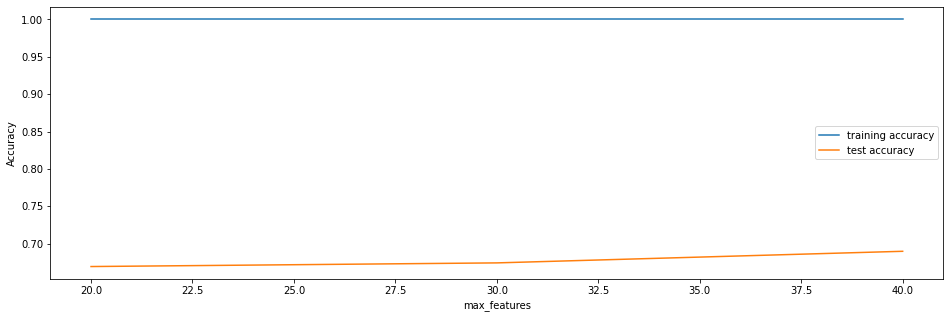

In [139]:
# parameters to build the model on
parameters = {'max_features': [20,30,40]}
tune_hyperparameter(parameters,X_train, y_train,4)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



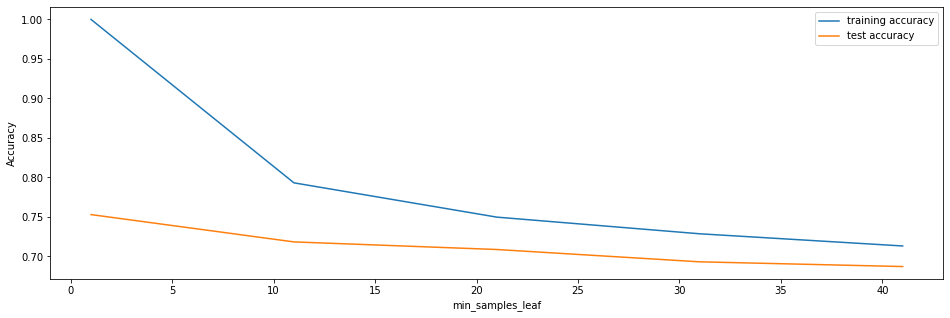

In [141]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(1, 50, 10)}
tune_hyperparameter(parameters,X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.0min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



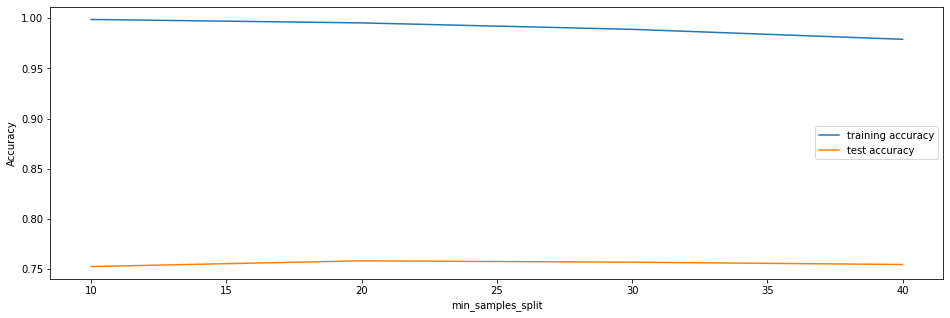

In [142]:
# parameters to build the model on
parameters = {'min_samples_split': range(10, 50, 10)}
tune_hyperparameter(parameters,X_train, y_train)

In [146]:
#### We will try to tune the Random Forest using heuristic values of Grid Search CV

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [5,9],
    'max_features': [40],
    'min_samples_leaf': [35,40],
    'min_samples_split': [35,40]
}

rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = params, 
                          cv = 5, n_jobs = -1,verbose = 1, scoring= "accuracy", 
                          return_train_score=True)

In [147]:
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   53.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [148]:
print("We can get accuracy of {} using \n{}".format(round(rf_grid_search.best_score_,2),rf_grid_search.best_params_))

We can get accuracy of 0.35 using 
{'max_depth': 9, 'max_features': 40, 'min_samples_leaf': 35, 'min_samples_split': 35}


#### Random Forest is not giving great results, with an accuracy of mere 35%
